# 1. Preparación de Entorno. 

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import numpy as np
from pmdarima import auto_arima
%pip install statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose
import ruptures as rpt
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

Note: you may need to restart the kernel to use updated packages.


# 2. Carga de Datos. 

## Acuíferos. 

In [2]:
# Load the aquifer hydrology data
df_aquifers = pd.read_csv("../data/processed/aquifers/aquifer_hydrology_data_clean.csv")
df_aquifers.head()

/var/folders/z5/1t80mr5s6n10j0fkr7bb6x6c0000gn/T/ipykernel_61713/7009082.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df_aquifers = pd.read_csv("../data/processed/aquifers/aquifer_hydrology_data_clean.csv")


,Date,was_nan,Value,Medition_Types,Location
0,1999-01-01,1,0.0,1,1
1,2000-01-01,1,0.0,1,1
2,2001-01-01,1,0.0,1,1
3,2002-01-01,1,0.0,1,1
4,2003-01-01,1,0.0,1,1


## Lagos. 

In [3]:
# Load the lake hydrology data
df_lakes = pd.read_csv("../data/processed/lakes/lake_hydrology_data_clean.csv")
df_lakes.head()

,Date,Value,Measurement_Types,Location
0,2002-06-03,0.0,1,1
1,2002-06-04,0.0,1,1
2,2002-06-05,0.0,1,1
3,2002-06-06,0.0,1,1
4,2002-06-07,0.0,1,1


## Ríos. 

In [4]:
# Load the river hydrology data
df_rivers = pd.read_csv("../data/processed/rivers/river_hydrology_data_clean.csv")
df_rivers.head()

,Date,Value,Measurement_Types,Location
0,1998-01-01,0.0,1,1
1,1998-01-02,0.0,1,1
2,1998-01-03,0.0,1,1
3,1998-01-04,0.0,1,1
4,1998-01-05,0.0,1,1


## Manantiales. 

In [5]:
# Load the water spring hydrology data
df_water_spring = pd.read_csv("../data/processed/water_spring/water_spring_hydrology_data_clean.csv")
df_water_spring.head()

,Date,Value,Measurement_Types,Location
0,2000-01-01,0.0,1,1
1,2001-01-01,0.0,1,1
2,2002-01-01,0.0,1,1
3,2003-01-01,0.0,1,1
4,2004-01-01,0.0,1,1


# 3. Definir Features (X) y Variable Target (Y). 

Para definir las variables features y la variable target, se considerarán los datos que nos son útiles para visualizar el nivel de agua según la fecha de cada cuerpo de agua, en este caso __"Value"__ es la variable target, mientras que el resto de las variables se considerarán variables feature.

# 4. Dividir data en train y test. 

In [6]:
import pandas as pd

def split_time_series_by_percentage(df, split_percentage):
    """
    Splits a time series DataFrame into training and testing sets
    based on a specified percentage. The DataFrame must be ordered chronologically.

    Args:
        df (pd.DataFrame): The input time series DataFrame.
        split_percentage (float): The percentage of data to use for the training set (e.g., 0.8 for 80%).

    Returns:
        tuple: A tuple containing the training and testing DataFrames (train_df, test_df).
    """
    if not 0 < split_percentage < 1:
        raise ValueError("split_percentage must be between 0 and 1.")

    split_point = int(len(df) * split_percentage)
    
    train_df = df.iloc[:split_point]
    test_df = df.iloc[split_point:]
    
    return train_df, test_df

# Example usage:
# Assuming 'df' is your time series DataFrame, already sorted by date.
# train_data, test_data = split_time_series_by_percentage(df, 0.8)

# print("Train Data:")
# print(train_data)
# print("\nTest Data:")
# print(test_data)

In [7]:
# Split the aquifer data into training and testing sets
train_data_aquifers, test_data_aquifers = split_time_series_by_percentage(df_aquifers, 0.8)

In [8]:
# Split the lakes data into training and testing sets
train_data_lakes, test_data_lakes = split_time_series_by_percentage(df_lakes, 0.8)

In [9]:
# Split the rivers data into training and testing sets
train_data_rivers, test_data_rivers = split_time_series_by_percentage(df_rivers, 0.8)

In [10]:
# Split the water_spring data into training and testing sets
train_data_water_spring, test_data_water_spring = split_time_series_by_percentage(df_water_spring, 0.8)

# 5. Análisis de Series de Tiempo. 

In [11]:
train_data_aquifers['Date'] = pd.to_datetime(train_data_aquifers['Date'], errors='coerce')

/var/folders/z5/1t80mr5s6n10j0fkr7bb6x6c0000gn/T/ipykernel_61713/2953720666.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data_aquifers['Date'] = pd.to_datetime(train_data_aquifers['Date'], errors='coerce')


In [12]:
train_data_aquifers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 273974 entries, 0 to 273973
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   Date            8154 non-null    datetime64[ns]
 1   was_nan         273974 non-null  int64         
 2   Value           273974 non-null  float64       
 3   Medition_Types  273974 non-null  int64         
 4   Location        273974 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(3)
memory usage: 10.5 MB


In [13]:
train_data_aquifers['Date'] = train_data_aquifers['Date'].dt.date

/var/folders/z5/1t80mr5s6n10j0fkr7bb6x6c0000gn/T/ipykernel_61713/383748217.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data_aquifers['Date'] = train_data_aquifers['Date'].dt.date


In [14]:
all_data = train_data_aquifers.set_index('Date')

In [15]:
ts = all_data["Value"]

In [16]:
ts.head()

Date
1999-01-01    0.0
2000-01-01    0.0
2001-01-01    0.0
2002-01-01    0.0
2003-01-01    0.0
Name: Value, dtype: float64

Punto de quiebre detectado en el índice: 610, fecha: 2014-10-15 00:00:00
Punto de quiebre detectado en el índice: 620, fecha: 2015-01-11 00:00:00
Punto de quiebre detectado en el índice: 800, fecha: 2020-01-25 00:00:00
Punto de quiebre detectado en el índice: 805, fecha: 2020-03-13 00:00:00


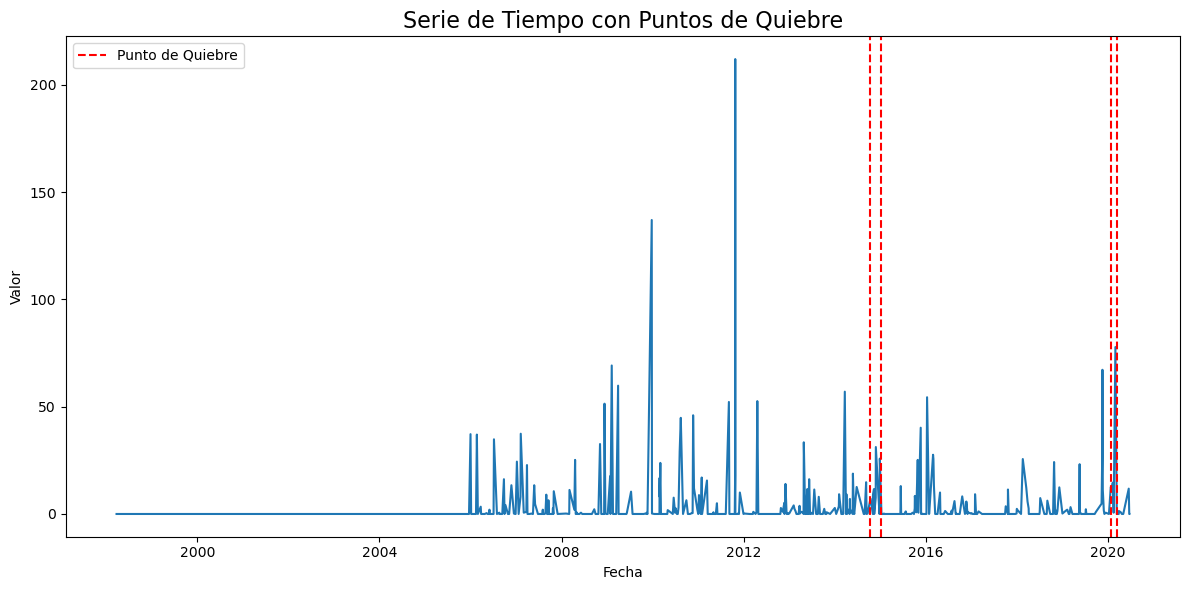

In [17]:

# Reemplaza 'train_data_aquifers' con tu DataFrame real
# y 'Date' y 'Value' con los nombres de tus columnas si son diferentes.
# df = pd.read_csv('tu_archivo.csv') # Ejemplo para cargar tus datos
df = train_data_aquifers.copy()

# Paso 1: Limpieza y preparación del DataFrame.
# Asegúrate de que la columna de fechas esté en el formato correcto
df['Date'] = pd.to_datetime(df['Date'])
# Elimina filas con valores de fecha no válidos (NaT)
df.dropna(subset=['Date'], inplace=True)
# Ordena el DataFrame por la columna de fechas
df.sort_values(by='Date', inplace=True)
# Establece la columna de fechas como el índice
df.set_index('Date', inplace=True)

# Paso 2: Muestreo y limpieza de valores nulos o infinitos.
# Esto es para que el kernel no se bloquee con datos grandes
sample_size = 0.1  # 10% de tus datos
df_sampled = df.sample(frac=sample_size, random_state=42)
# Reordena el DataFrame después del muestreo para el gráfico
df_sampled.sort_index(inplace=True)
# Limpia los datos de la muestra antes de la detección
df_sampled = df_sampled.replace([np.inf, -np.inf], np.nan).dropna()

# Paso 3: Escalar los datos para la detección de quiebres.
values_original = df_sampled['Value'].values.reshape(-1, 1)
scaler = StandardScaler()
values_scaled = scaler.fit_transform(values_original)

# Paso 4: Detección de puntos de quiebre.
# Usa BinSeg, que es más rápido y robusto para datos grandes.
# Aquí le decimos que busque 1 punto de quiebre. Puedes ajustar este valor. 
algo = rpt.Pelt(model="l1").fit(values_scaled)
result = algo.predict(pen=1)

# Paso 5: Graficar la serie de tiempo con los puntos de quiebre.
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(df_sampled.index, values_original)
ax.set_title('Serie de Tiempo con Puntos de Quiebre', fontsize=16)
ax.set_xlabel('Fecha')
ax.set_ylabel('Valor')

for cp in result[:-1]:
    ax.axvline(x=df_sampled.index[cp], color='red', linestyle='--', label='Punto de Quiebre' if cp == result[0] else "")
    print(f"Punto de quiebre detectado en el índice: {cp}, fecha: {df_sampled.index[cp]}")

plt.legend()
plt.tight_layout()
plt.show()

/Users/bereniceramos/miniconda3/envs/new_pmdarima_env/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


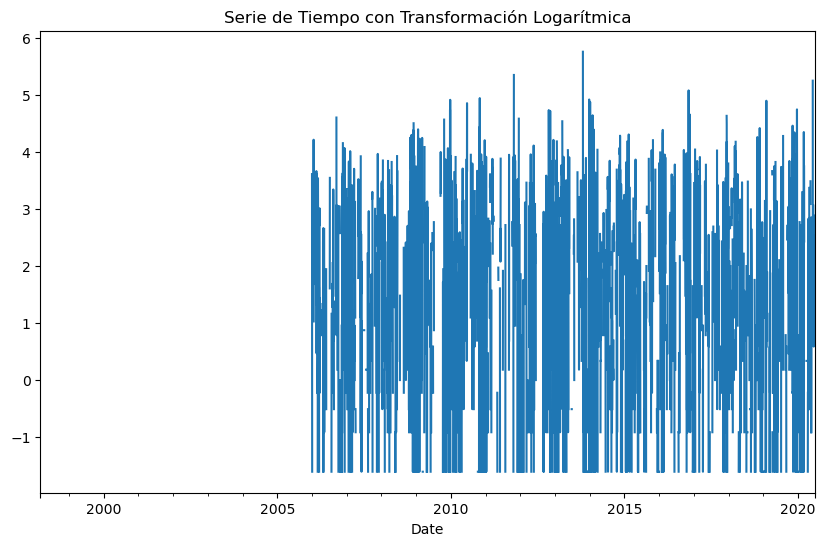

In [18]:
# --- 2. Estabilizar la Varianza (Transformación Logarítmica) ---
df['log_value'] = np.log(df['Value'])
df['log_value'].plot(title='Serie de Tiempo con Transformación Logarítmica', figsize=(10, 6))
plt.show()

In [19]:
df['log_value'].unique()

array([       -inf,  3.61630876,  1.16315081, -1.60943791,  1.68639895,
        4.21950771,  1.02961942,  2.39789527,  3.48431229,  2.8678989 ,
        2.10413415,  0.58778666,  1.33500107,  3.66867675,  3.03495299,
        0.47000363,  2.19722458,  3.17805383,  3.61091791,  2.37954613,
        1.64865863, -0.22314355,  0.        ,  2.99573227,  3.20274644,
        3.54385368,  3.0155349 ,  0.69314718,  1.88706965,  1.60943791,
        2.72129543,  1.22377543,  1.43508453, -0.51082562,  0.78845736,
        0.95551145,  2.41591378, -0.91629073,  2.66722821,  2.02814825,
        2.65324196,  2.43361336,  1.94591015,  1.48160454,  1.7227666 ,
        3.54961739,  1.56861592,  1.28093385,  2.05412373,  2.89037176,
        3.34638915,  3.15273602,  1.38629436,  1.85629799,  4.60916221,
        3.06339092,  0.18232156,  2.78501124,  3.05400118,  3.04452244,
        2.73436751,  2.58021683,  2.8094027 ,  3.56671182,  3.6323091 ,
        4.15888308,  2.59525471,  3.09104245,  3.64283552,  1.09

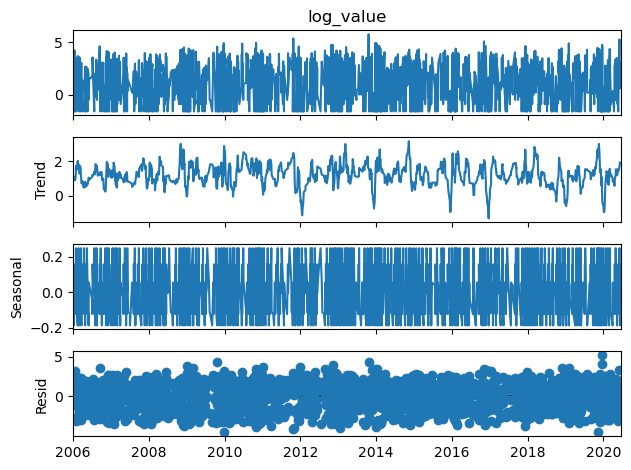

In [20]:
# 1. Aplicar la transformación logarítmica

# 2. Reemplazar los valores infinitos con NaN
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# 3. Eliminar o rellenar los valores NaN
# Opción A: Eliminar las filas con NaN
df_cleaned = df.dropna(subset=['log_value'])

# Opción B: Rellenar con interpolación lineal
#df['log_value'].interpolate(method='linear', inplace=True)

# 4. Ahora puedes ejecutar la descomposición en el DataFrame limpio
# Usando la Opción A:
decomposition = seasonal_decompose(df_cleaned['log_value'], model='additive', period=12)

# O usando la Opción B:
#decomposition = seasonal_decompose(df['log_value'], model='additive', period=12)

decomposition.plot()
plt.show()

/var/folders/z5/1t80mr5s6n10j0fkr7bb6x6c0000gn/T/ipykernel_61713/701075448.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['diff_estacional'] = df_cleaned['log_value'].diff(periods=12).dropna()


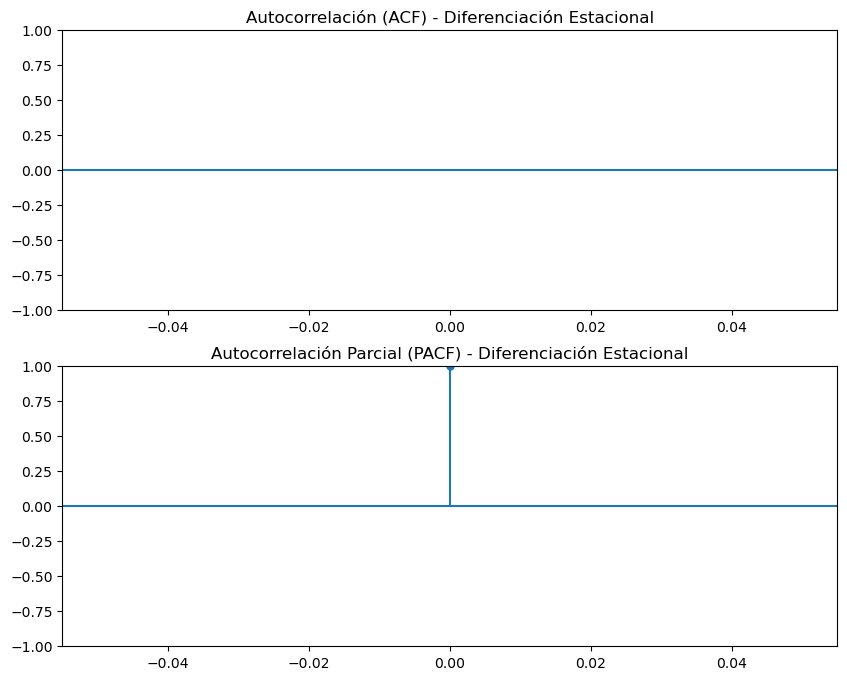

In [21]:
# Suponiendo que 'df' es tu DataFrame y 'log_value' es la columna transformada

# --- Opción 1: Diferenciación normal ---
# Elimina la tendencia
# df['diff_normal'] = df['log_value'].diff().dropna()

# # Graficar ACF y PACF de la serie diferenciada
# fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
# plot_acf(df['diff_normal'], ax=ax1, lags=30)
# plot_pacf(df['diff_normal'], ax=ax2, lags=30)
# ax1.set_title('Autocorrelación (ACF) - Diferenciación Normal')
# ax2.set_title('Autocorrelación Parcial (PACF) - Diferenciación Normal')
# plt.show()

# --- Opción 2: Diferenciación estacional ---
# Elimina la estacionalidad (ej. para datos mensuales, period=12)
df_cleaned['diff_estacional'] = df_cleaned['log_value'].diff(periods=12).dropna()

# Graficar ACF y PACF de la serie diferenciada estacionalmente
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(df_cleaned['diff_estacional'], ax=ax1, lags=30)
plot_pacf(df_cleaned['diff_estacional'], ax=ax2, lags=30)
ax1.set_title('Autocorrelación (ACF) - Diferenciación Estacional')
ax2.set_title('Autocorrelación Parcial (PACF) - Diferenciación Estacional')
plt.show()

Análisis de Tendencia y Volatilidad por Segmento:

--- Segmento 1 ---
Fechas: 2006-01-01 a 2010-05-02
Media (Nivel): 11.69
Desviación Estándar (Volatilidad): 17.63
Cambio en la Tendencia: -35.40

--- Segmento 2 ---
Fechas: 2010-05-03 a 2010-05-13
Media (Nivel): 16.92
Desviación Estándar (Volatilidad): 12.01
Cambio en la Tendencia: -20.00

--- Segmento 3 ---
Fechas: 2010-05-14 a 2011-10-28
Media (Nivel): 15.70
Desviación Estándar (Volatilidad): 25.56
Cambio en la Tendencia: -10.20

--- Segmento 4 ---
Fechas: 2011-11-04 a 2011-11-08
Media (Nivel): 30.08
Desviación Estándar (Volatilidad): 17.92
Cambio en la Tendencia: 34.20

--- Segmento 5 ---
Fechas: 2011-11-09 a 2020-06-17
Media (Nivel): 12.44
Desviación Estándar (Volatilidad): 21.30
Cambio en la Tendencia: 9.20



/var/folders/z5/1t80mr5s6n10j0fkr7bb6x6c0000gn/T/ipykernel_61713/1875722769.py:36: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(segments))


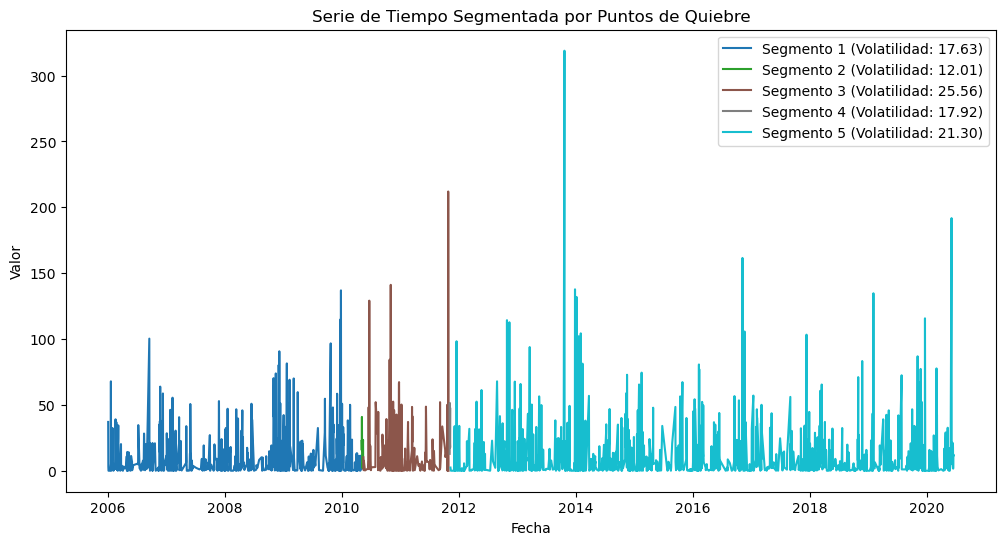

In [27]:
# Asume que 'df_cleaned' es tu DataFrame con la serie de tiempo ya limpia,
# ordenada y con el índice de fechas, y 'result' es la lista de índices
# de los puntos de quiebre del algoritmo ruptures.
# Ejemplo: df_cleaned['Value'] es la columna de valores

# --- 1. Definir los segmentos con los puntos de quiebre ---
break_points = [0] + result[:-1] + [len(df_cleaned)]
segments = []

for i in range(len(break_points) - 1):
    start = break_points[i]
    end = break_points[i+1]
    segments.append(df_cleaned.iloc[start:end])

# --- 2. Analizar la tendencia y volatilidad de cada segmento ---
print("Análisis de Tendencia y Volatilidad por Segmento:\n")
for i, segment in enumerate(segments):
    if segment.empty:
        continue
    
    # Calcular la media y la desviación estándar para la variabilidad
    mean_val = segment['Value'].mean()
    std_dev_val = segment['Value'].std()
    
    # Analizar la tendencia (puedes usar regresión lineal para una mejor estimación)
    trend = segment['Value'].iloc[-1] - segment['Value'].iloc[0]
    
    print(f"--- Segmento {i+1} ---")
    print(f"Fechas: {segment.index.min().strftime('%Y-%m-%d')} a {segment.index.max().strftime('%Y-%m-%d')}")
    print(f"Media (Nivel): {mean_val:.2f}")
    print(f"Desviación Estándar (Volatilidad): {std_dev_val:.2f}")
    print(f"Cambio en la Tendencia: {trend:.2f}\n")

# --- 3. Visualizar los segmentos con sus propiedades ---
plt.figure(figsize=(12, 6))
colors = plt.cm.get_cmap('tab10', len(segments))

for i, segment in enumerate(segments):
    plt.plot(segment.index, segment['Value'], color=colors(i), 
             label=f'Segmento {i+1} (Volatilidad: {segment["Value"].std():.2f})')

plt.title('Serie de Tiempo Segmentada por Puntos de Quiebre')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.show()

In [29]:
df_cleaned.head()

,was_nan,Value,Medition_Types,Location,log_value,diff_estacional
Date,,,,,,
2006-01-01,1,37.2,1,1,3.616309,NaN
2006-01-02,1,3.2,1,1,1.163151,NaN
2006-01-03,1,0.2,1,1,-1.609438,NaN
2006-01-09,1,0.2,1,1,-1.609438,NaN
2006-01-13,1,0.2,1,1,-1.609438,NaN


/var/folders/z5/1t80mr5s6n10j0fkr7bb6x6c0000gn/T/ipykernel_61713/3515852753.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['diff_estacional'] = df_cleaned['log_value'].diff(periods=12)


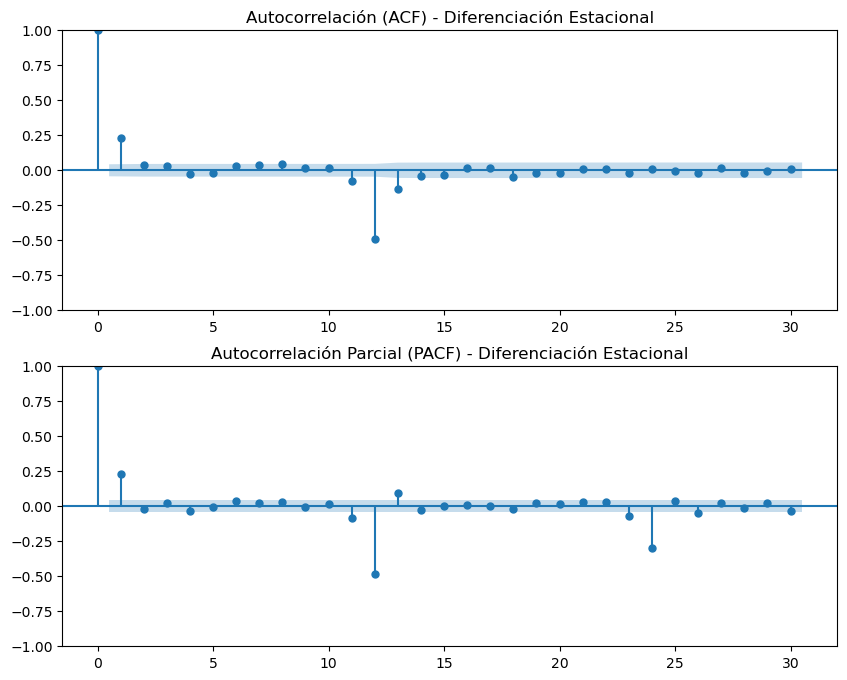

In [30]:
# Suponiendo que 'df' es tu DataFrame limpio con la columna 'log_value'

# Diferenciación estacional
df_cleaned['diff_estacional'] = df_cleaned['log_value'].diff(periods=12)

# Eliminar los NaN resultantes de la diferenciación
df_diff_estacional_cleaned = df_cleaned.dropna(subset=['diff_estacional'])

# Ahora puedes usar df_diff_estacional_cleaned para graficar
# la autocorrelación (ACF) y autocorrelación parcial (PACF).

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(df_diff_estacional_cleaned['diff_estacional'], ax=ax1, lags=30)
plot_pacf(df_diff_estacional_cleaned['diff_estacional'], ax=ax2, lags=30)
ax1.set_title('Autocorrelación (ACF) - Diferenciación Estacional')
ax2.set_title('Autocorrelación Parcial (PACF) - Diferenciación Estacional')
plt.show()

In [32]:

# Entrena el modelo SARIMA con los parámetros identificados
print("Entrenando modelo SARIMA(1,0,1)(1,1,1,12)...")

# Asegúrate de usar la serie original transformada ('log_value') para el modelo
# La diferenciación se realiza internamente en el modelo SARIMA
model = SARIMAX(df_cleaned['log_value'], 
                order=(1, 0, 1), 
                seasonal_order=(1, 1, 1, 12),
                enforce_stationarity=False, 
                enforce_invertibility=False)

results = model.fit()

# Muestra el resumen del modelo entrenado
print(results.summary())

Entrenando modelo SARIMA(1,0,1)(1,1,1,12)...


/Users/bereniceramos/miniconda3/envs/new_pmdarima_env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/bereniceramos/miniconda3/envs/new_pmdarima_env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                          log_value   No. Observations:                 2085
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 12)   Log Likelihood               -4116.427
Date:                            Thu, 21 Aug 2025   AIC                           8242.854
Time:                                    22:28:48   BIC                           8271.004
Sample:                                         0   HQIC                          8253.175
                                           - 2085                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1374      0.093      1.484      0.138      -0.044       0.319
ma.L1          0.0923      0.093   

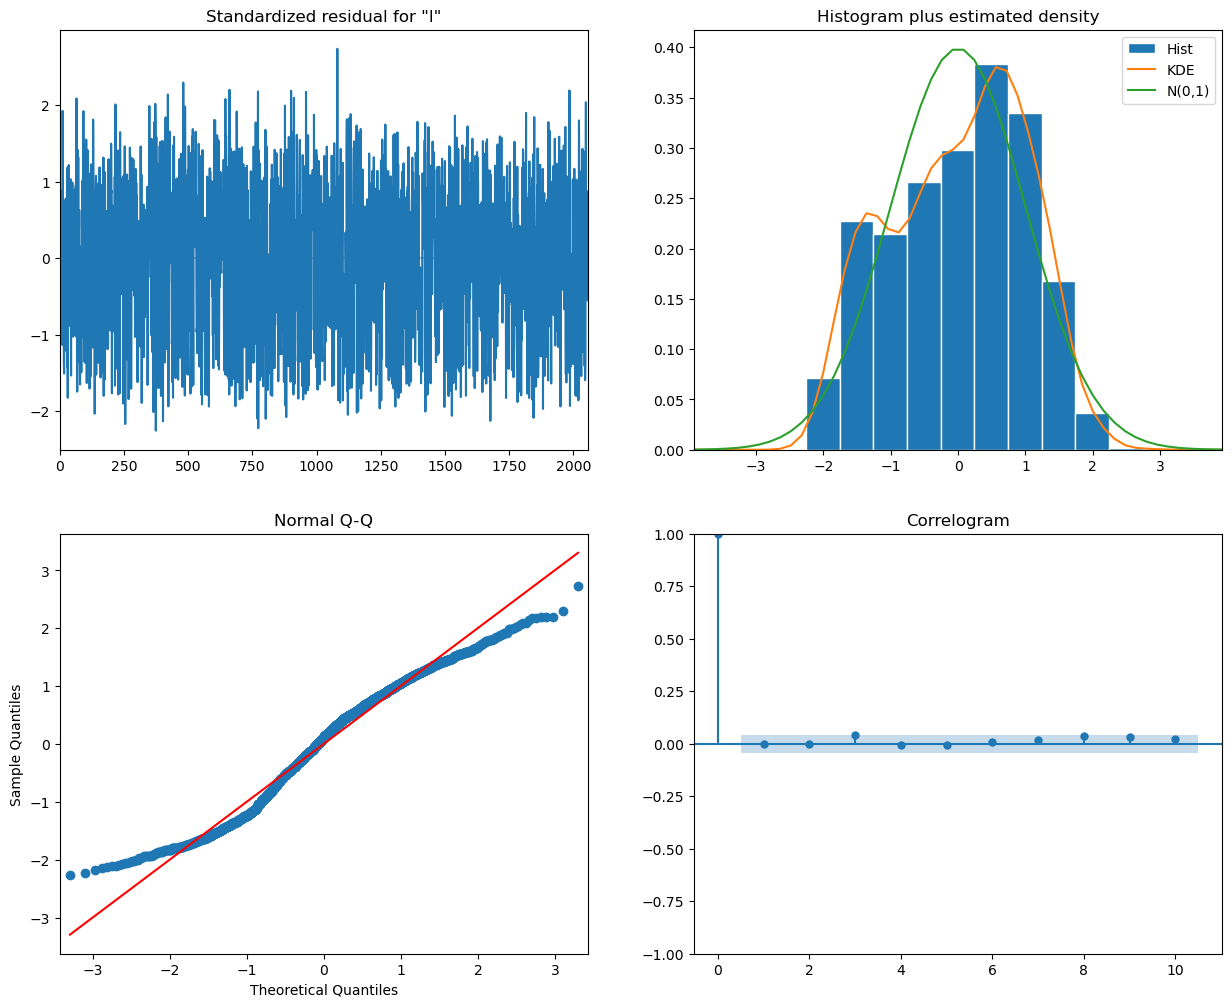

In [33]:
# Muestra los gráficos de diagnóstico del modelo
results.plot_diagnostics(figsize=(15, 12))
plt.show()

### Prueba de Dickey-Fuller (Dickey-Fuller test).

In [26]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    print("Resultados de la prueba de Dickey-Fuller:")
    dftest = adfuller(timeseries, autolag = "AIC")
    dfoutput = pd.Series(dftest[0:4], index = ["Test Statistic", "p-value", "#Lags Used", "Number of Observations Used"])
    for key,value in dftest[4].items():
        dfoutput["Critical Value (%s)"%key] = value
    return dfoutput

test_stationarity(ts)

Resultados de la prueba de Dickey-Fuller:


KeyboardInterrupt: 

# 6. Evaluar modelos e Hiperpárametros.

# 7. Guardar Modelos. 